# Part 2 - 2: Tokenization 

In this section of the Notebook, we are interested in two tasks: computing **unique tokens found before sentence segmentation** (that is, the vocabulary of the dataset)  and **computing tokens found after sentence segmentation** (that is, token occurrences found in sentences of the dataset). For each of these tasks, we will compare

1) NLTK and spaCy's results

2) the intersection of their results

3) the results that are specific to each of these libraries

In this part, we are not interested yet in POS (this will be the last part of the project). However, we choose to do all computations at once: we will compute POS at the same time as tokenization, so the data will be stored and later reused.


## 0. Imports and function definitions (tokenization)

In [1]:
# add util.py to the path
import sys
sys.path.append('../')
from util import clean_text

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import WordPunctTokenizer
nltk.download('punkt')
from nltk.tag import pos_tag
nltk.download('stopwords')

# spaCy imports
import spacy
from spacy.tokenizer import Tokenizer
nlp_spacy =spacy.load("en_core_web_sm")

# Other imports
import pandas as pd
import seaborn as sns

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bleuze3u\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Below, we code a function that will, sentence by sentence, perform tokenization of the sentence using NLTK. The results are given in the form of a set of tokens (their written form), the index they start at in the sentence, and their part-of-speech.

In [2]:
def get_tokens_set_NLTK(sentence):
    """A function that returns a set of tokens from a sentence using NLTK's WordPunctTokenizer, along 
    with the index of the first character of each token and their part of speech""" 

    # Tokens and their part of speech
    tokens_and_pos = list(pos_tag(WordPunctTokenizer().tokenize(sentence), tagset='universal'))
    # Spans of the tokens 
    spans = list(WordPunctTokenizer().span_tokenize(sentence))

    # Store the token, the index of the first character and the part of speech
    tokens_and_pos_and_spans = [(token[0], i, token[1]) for (token, (i, j)) in zip(tokens_and_pos, spans)]

    return set(tokens_and_pos_and_spans)

Now, we do the same with spaCy. It is important to note that NLTK's universal tagset and spaCy's universal tagset are not exactly the same. Actually, spacy matches UPOS conventions better, but the problem is that NLTK's tags are sometimes less specific. For example, NLTK has tag CONJ, whereas spacy has CCONJ and SCONJ. This is the reason why we will map spacy's tags to NLTK's universal tags (given that spaCy has more of them).

In [3]:
# Creating a mapping from spaCy's part of speech tags to the universal part of speech tags
spacy_tags_to_nltk = {
    "ADJ" : "ADJ",
    "ADV" : "ADV",
    "NOUN" : "NOUN",
    "VERB" : "VERB",
    "INTJ" : "X", # an interjection falls into the category "others"
    "PROPN" : "NOUN", # a proper noun is a noun
    "ADP" : "ADP",
    "AUX" : "VERB", # an auxiliary verb is a verb
    "CCONJ" : "CONJ", # a coordinating conjunction is a conjunction
    "DET" : "DET",
    "NUM" : "NUM",
    "PART" : "PRT", # just a change in notation
    "PRON" : "PRON",
    "SCONJ" : "CONJ", # a subordinating conjunction is a conjunction
    "PUNCT" : ".", # just a change in notation
    "SYM" : "X", # a symbol falls into the category "others"
    "X" : "X" }

In [4]:
def get_tokens_set_spacy(text):
    """A function that returns a set of tokens from a text using spaCy default tokenizer, along 
    with the index of the first character of each token and their part of speech""" 

    doc_spacy = nlp_spacy(text)

    return set([(token.text, token.idx, spacy_tags_to_nltk[token.pos_]) for token in doc_spacy])

Here is a brief example of the way these function work.

In [5]:
s="Hey ! This is a test sentence and I love it . How great ! u-2"
nltk_ = get_tokens_set_NLTK(s)
spacy_ = get_tokens_set_spacy(s)
print("NLTK: ", nltk_)
print("Spacy: ", spacy_)

print("\nCommon tokens and POS: ", nltk_.intersection(spacy_))
print("\nNLTK only: ", nltk_.difference(spacy_))
print("\nSpacy only: ", spacy_.difference(nltk_))

NLTK:  {('u', 58, 'ADJ'), ('This', 6, 'DET'), ('sentence', 21, 'NOUN'), ('I', 34, 'PRON'), ('!', 4, '.'), ('a', 14, 'DET'), ('!', 56, '.'), ('-', 59, '.'), ('test', 16, 'NOUN'), ('great', 50, 'ADJ'), ('it', 41, 'PRON'), ('love', 36, 'VERB'), ('How', 46, 'ADV'), ('.', 44, '.'), ('2', 60, 'NUM'), ('Hey', 0, 'NOUN'), ('and', 30, 'CONJ'), ('is', 11, 'VERB')}
Spacy:  {('sentence', 21, 'NOUN'), ('I', 34, 'PRON'), ('!', 4, '.'), ('a', 14, 'DET'), ('!', 56, '.'), ('test', 16, 'NOUN'), ('great', 50, 'ADJ'), ('it', 41, 'PRON'), ('love', 36, 'VERB'), ('u-2', 58, '.'), ('Hey', 0, 'X'), ('.', 44, '.'), ('How', 46, 'CONJ'), ('This', 6, 'PRON'), ('and', 30, 'CONJ'), ('is', 11, 'VERB')}

Common tokens and POS:  {('I', 34, 'PRON'), ('!', 4, '.'), ('a', 14, 'DET'), ('!', 56, '.'), ('is', 11, 'VERB'), ('test', 16, 'NOUN'), ('great', 50, 'ADJ'), ('it', 41, 'PRON'), ('love', 36, 'VERB'), ('.', 44, '.'), ('and', 30, 'CONJ'), ('sentence', 21, 'NOUN')}

NLTK only:  {('u', 58, 'ADJ'), ('This', 6, 'DET'), ('-',

## 1. Vocabulary comparison (SharedTokensNoSentences)

In this part, we will perform tokenization using NLTK and spaCy on the whole dataset, without previous sentence segmentation. We will compare the vocabulary that both these libraries find.  
  
First, we load our dataset.

In [6]:
# Dataset loading
with open('../../data/part2/dataset.txt') as f:
    text = f.read()

Now, we will clean the text and perform the tokenization. Here, we are only interested in the token forms, which is why we only look at the first element of the tuple (token, start_index, POS) for the two libraries.

In [7]:
#Get clean text by removing redundant symbols
Clean_text=clean_text(text)

#Get the tokens by NLTK (only their form)
tokens_NLTK = set([tok[0] for tok in get_tokens_set_NLTK(Clean_text)])

#Get the number of  tokens by NLTK
nb_tokens_NLTK = len(tokens_NLTK)

#Get the tokens by Spacy (only their form)
tokens_Spacy = set([tok[0] for tok in get_tokens_set_spacy(Clean_text)])

#Get the number of tokens by Spacy
nb_tokens_Spacy = len(tokens_Spacy)

#Get the set of common tokens recognized by NLTK and Spacy
common_token=set(tokens_NLTK) & set(tokens_Spacy)

#Get number of set of common tokens recognized by NLTK and Spacy
nb_common_token=len(common_token)

#Get the set of tokens exist only in NLTK
only_token_NLTK=set(tokens_NLTK).difference(set(common_token))

#Get the number of set of tokens exist only in NLTK
nb_only_token_NLTK=len(only_token_NLTK)

#Get the set of tokens exist only in Spacy
only_token_Spacy=set(tokens_Spacy).difference(set(common_token))

#Get the number of set of tokens exist only in Spacy
nb_only_token_Spacy=len(only_token_Spacy)

print("Tokens obtained by NLTK: ", tokens_NLTK )
print("Number of tokens obtained by NLTK: ",nb_tokens_NLTK)
print("---"*100)

print("Tokens obtained by Spacy: ", tokens_Spacy )
print("Number of tokens obtained by Spacy: ",nb_tokens_Spacy)
print("---"*100)

print("Common tokens recognized by NLTK and Spacy: ", common_token)
print("Number of common tokens recognized by NLTK and Spacy: ", nb_common_token)
print("---"*100)

print("Tokens exist only in NLTK: ", only_token_NLTK)
print("Number of tokens exist only in NLTK: ", nb_only_token_NLTK)
print("---"*100)

print("Tokens exist only in Spacy: ", only_token_Spacy)
print("Number of tokens exist only in Spacy: ", nb_only_token_Spacy)


Tokens obtained by NLTK:  {'time', 'can', 'einstein', 'problem', 'alternative', 'important', 'tell', 'theses', '37', '1294', 'unity', 'race', 'organum', 'cross', 'concerned', 'proven', 'theories', 'mathematics', 'speculation', 'often', 'next', 'related', 'w', 'realists', '—', 'individual', '1214', 'would', '1637', 'causal', 'different', 'through', 'coherent', '".', 'ground', 'david', 'under', 'disagree', 'influence', 'suspect', 'part', 'yet', 'generalizing', 'interpretation', 'and', 'come', 'thinking', 'true', 'materialism', 'validated', 'quine', 'is', 'sociology', 'engaged', 'newton', 'product', 'developed', 'reliability', 'alternatively', 'sensory', 'around', 'set', 'up', 'influential', 'reasoning', 'old', 'investigated', 'model', 'every', 'justification', 'relied', 'against', 'grounded', 'popper', 'if', 'each', 'improve', 'personal', 'such', 'basic', 'by', 'phenomenon', 'instance', 'hundreds', 'recent', 'closely', 'minority', 'effective', 'framework', 'nature', 'falsifiability', 'wi

Now we will save these results and visualize the counts in a graph.

In [8]:
# Save the results in a dataframe
df = pd.DataFrame(columns = ["NLTK_all", "NLTK_only", "spaCy_all", "spaCy_only", "shared"], data = [[tokens_NLTK, only_token_NLTK, tokens_Spacy, only_token_Spacy, common_token]])
df.to_csv("../../data/part2/tokens.csv", index = False)

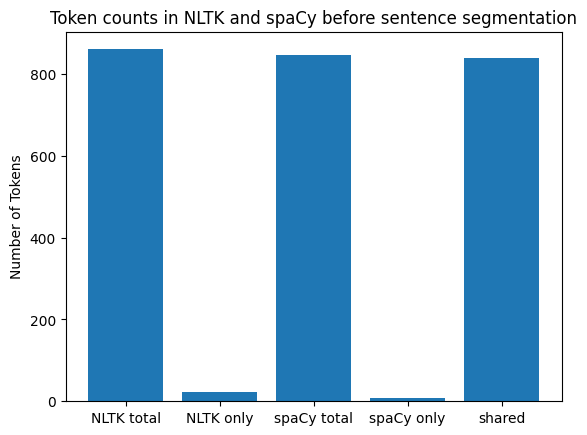

In [9]:
import matplotlib.pyplot as plt

# Define the data for the graph
x= ['NLTK total','NLTK only', 'spaCy total', 'spaCy only', 'shared',]
y= [nb_tokens_NLTK, nb_only_token_NLTK, nb_tokens_Spacy,nb_only_token_Spacy, nb_common_token]

plt.bar(x, y)
     
# Add labels to the graph
plt.title('Token counts in NLTK and spaCy before sentence segmentation')
plt.ylabel('Number of Tokens')

# Show the graph
plt.savefig('../../data/plots/2-token-counts.png')
plt.show()

# 2. Token occurrences comparison (SharedTokensInSentences)

Now, we will compare the tokenization results of the two libraries *after sentence segmentation*. Because we already studied the difference in sentence segmentation performance between NLTK and spaCy (see [this Notebook](1-data-collection-and-sentence-segmentation.ipynb)), we will directly work on the *sentences that were identified by the two libraries (shared sentences)*.

In [10]:
# Load shared sentences list
df=pd.read_csv("../../data/part2/part2-shared-sentences.csv")

In [11]:
#Get clean articles by removing redundant symbols
df["Clean_shared_sentence"] = df["shared_sentence"].apply(clean_text)
df

,shared_sentence,Clean_shared_sentence
0,"Values emerge from science, both as product an...","values emerge from science, both as product an..."
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont..."
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h..."
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...
9,In addition to these general questions about s...,in addition to these general questions about s...


In [12]:
#Get the tokens by NLTK in each sentence
df["NLTK_tokens"] = df["Clean_shared_sentence"].apply(get_tokens_set_NLTK)
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2..."
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd..."
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,..."
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug..."
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ..."
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE..."
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V..."
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin..."
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,..."
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics..."


In [13]:
# Get the number of token by NLTK for each sentence
df['nb_NLTK_tokens'] = df['NLTK_tokens'].apply(lambda x: len(x))
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29


In [14]:
# Count the total number of tokens by NLTK for all sentences
all_tokens_NLTK=df['nb_NLTK_tokens'].sum()
all_tokens_NLTK

412

In [15]:
#Get the token by Spacy for each sentence
df["Spacy_tokens"] = df["Clean_shared_sentence"].apply(get_tokens_set_spacy)
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ..."
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd..."
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR..."
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent..."
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,..."
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE..."
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V..."
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin..."
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160..."
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics..."


In [16]:
# Get the number of token by Spacy for each sentence
df['nb_Spacy_tokens'] = df['Spacy_tokens'].apply(lambda x: len(x))
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30


In [17]:
# Count the total number of tokens by Spacy for all sentences
all_tokens_Spacy=df['nb_Spacy_tokens'].sum()
all_tokens_Spacy

414

In [18]:
#Get the set of common tokens recognized by NLTK and Spacy in each sentence
df['common_tokens'] = [set([(elt[0], elt[1]) for elt in a]) & set([(elt[0], elt[1]) for elt in b]) for a, b in zip(df.Spacy_tokens, df.NLTK_tokens)]
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)..."
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7..."
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7..."
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ..."
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer..."
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas..."
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ..."
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a..."
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,..."
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,..."


In [19]:
#Get the number of common tokens recognized by NLTK and Spacy in each sentence
df['nb_common_tokens'] = df["common_tokens"].apply(lambda x: len(x))
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas...",28
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ...",19
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a...",39
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,...",33
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,...",28


In [20]:
#Get the set of tokens exist only in NLTK in each sentence
df['NLTK_only_tokens'] = [set([(elt[0], elt[1]) for elt in a]).difference(set([(elt[0], elt[1]) for elt in b])) for a, b in zip(df.NLTK_tokens,df.common_tokens)]
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{}
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{}
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{}
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{}
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{}
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas...",28,"{(cannot, 46)}"
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ...",19,{}
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a...",39,{}
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,...",33,"{(cannot, 150)}"
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,...",28,"{().., 168)}"


In [21]:
#Get the number set of tokens exist only in NLTK for  each sentence
df['nb_NLTK_only_tokens'] =  df["NLTK_only_tokens"].apply(lambda x: len(x))
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens,nb_NLTK_only_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{},0
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{},0
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{},0
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{},0
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{},0
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas...",28,"{(cannot, 46)}",1
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ...",19,{},0
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a...",39,{},0
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,...",33,"{(cannot, 150)}",1
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,...",28,"{().., 168)}",1


In [22]:
# Count the total number of tokens exist only in Spacy
only_tokens_NLTK=df['nb_NLTK_only_tokens'].sum()
only_tokens_NLTK

5

In [23]:
#Get the set of tokens exist only in Spacy for  each sentence
df['Spacy_only_tokens'] = [set([(elt[0], elt[1]) for elt in a]).difference(set([(elt[0], elt[1]) for elt in b])) for a, b in zip(df.Spacy_tokens, df.common_tokens)]
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens,nb_NLTK_only_tokens,Spacy_only_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{},0,{}
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{},0,{}
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{},0,{}
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{},0,{}
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{},0,{}
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas...",28,"{(cannot, 46)}",1,"{(can, 46), (not, 49)}"
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ...",19,{},0,{}
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a...",39,{},0,{}
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,...",33,"{(cannot, 150)}",1,"{(not, 153), (can, 150)}"
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,...",28,"{().., 168)}",1,"{(), 168), (.., 169)}"


In [24]:
#Get the number set of tokens exist only in Spacy for each sentence
df['nb_Spacy_only_tokens'] = df["Spacy_only_tokens"].apply(lambda x: len(x))
df

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens,nb_NLTK_only_tokens,Spacy_only_tokens,nb_Spacy_only_tokens
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{},0,{},0
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{},0,{},0
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{},0,{},0
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{},0,{},0
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{},0,{},0
5,One approach is to acknowledge that induction ...,one approach is to acknowledge that induction ...,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",29,"{(one, 0, NUM), (of, 101, ADP), (make, 137, VE...",30,"{(certainty, 61), (to, 16), (make, 137), (leas...",28,"{(cannot, 46)}",1,"{(can, 46), (not, 49)}",2
6,Philosophers have tried to make this heuristic...,philosophers have tried to make this heuristic...,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(make, 27, VERB), (in, 70, ADP), (have, 13, V...",19,"{(tried, 18), (in, 70), (make, 27), (precise, ...",19,{},0,{},0
7,There is no consensus among philosophers about...,there is no consensus among philosophers about...,"{(at, 241, ADP), (scientific, 203, ADJ), (thin...",39,"{(scientific, 203, ADJ), (at, 241, ADV), (thin...",39,"{(science, 136), (reveal, 148), (can, 144), (a...",39,{},0,{},0
8,So the chicken would be right to conclude from...,so the chicken would be right to conclude from...,"{(right, 24, ADJ), (certain, 160, ADJ), (come,...",34,"{(right, 24, ADJ), (.., 167, .), (certain, 160...",35,"{(it, 147), (again, 115), (conclude, 33), (be,...",33,"{(cannot, 150)}",1,"{(not, 153), (can, 150)}",2
9,In addition to these general questions about s...,in addition to these general questions about s...,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",29,"{(a, 56, DET), (sciences, 132, NOUN), (physics...",30,"{(such, 142), (science, 81), (that, 107), (in,...",28,"{().., 168)}",1,"{(), 168), (.., 169)}",2


In [25]:
# save the dataframe
df.to_csv("../../data/part2/part2-token-counts.csv", index = False)

In [26]:
# Count the total number of tokens exist only in Spacy for all sentences
only_tokens_spacy=df['nb_Spacy_only_tokens'].sum()
only_tokens_spacy

7

In [27]:
# Print out the sum of common tokens recognized by NLTK and Spacy  for all  sentences
sum_common_tokens=df['nb_common_tokens'].sum()
sum_common_tokens

407

In [28]:

print("Number of tokens obtained by NLTK: ",all_tokens_NLTK)
print("---"*100)


print("Number of tokens obtained by Spacy: ",all_tokens_Spacy)
print("---"*100)


print("Number of all common tokens recognized by NLTK and Spacy : ", sum_common_tokens)
print("---"*100)


print("Number of all tokens exist only in NLTK: ", only_tokens_NLTK)
print("---"*100)


print("Number of all tokens exist only in Spacy: ", only_tokens_spacy)

Number of tokens obtained by NLTK:  412
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of tokens obtained by Spacy:  414
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Number of all common tokens recognized by NLTK and Spacy :  407
-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

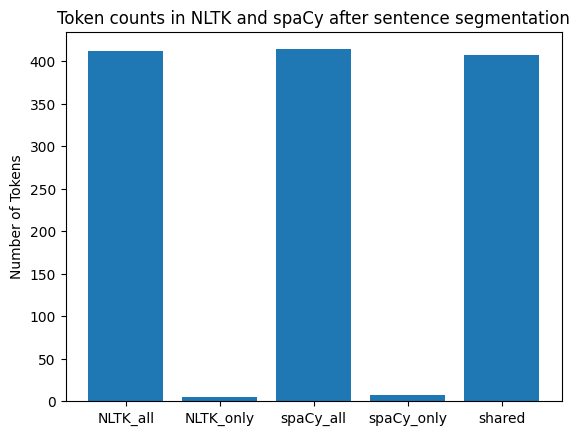

In [29]:
import matplotlib.pyplot as plt

# Define the data for the graph
x= ['NLTK_all','NLTK_only','spaCy_all', 'spaCy_only', 'shared',]
y= [all_tokens_NLTK, only_tokens_NLTK, all_tokens_Spacy, only_tokens_spacy, sum_common_tokens]

plt.bar(x, y)
     
# Add labels to the graph
plt.title('Token counts in NLTK and spaCy after sentence segmentation')
plt.ylabel('Number of Tokens')
plt.savefig('../../data/plots/2-token-counts-after-sentence-segmentation.png')

# Show the graph
plt.show()

# Part 2 - 3: POS Tagging

## 1. Comparing POS tags for common tokens

Now we are interested in the tokens that are identified by both NLTK and spaCY, and that also have been assigned the same POS tag by the two libraries.

In [30]:
df["common_tokens_and_POS"] = [set(a) & set(b) for a, b in zip(df.NLTK_tokens,df.Spacy_tokens)]
df["nb_common_tokens_and_POS"] = df["common_tokens_and_POS"].apply(len)
df.head()

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens,nb_NLTK_only_tokens,Spacy_only_tokens,nb_Spacy_only_tokens,common_tokens_and_POS,nb_common_tokens_and_POS
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{},0,{},0,"{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",20
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{},0,{},0,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",13
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{},0,{},0,"{(truth, 138, NOUN), (it, 89, PRON), (science,...",22
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{},0,{},0,"{(various, 14, ADJ), (been, 50, VERB), (potent...",30
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{},0,{},0,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",14


For the common tokens that were assigned different POS tags by NLTK and spaCy, we would like to know how they disagreed. So we compute NLTK's specific tags to common tokens, and the same for spaCy.

In [31]:
nltk_specific = [set(a).difference(set(b)) for a, b in zip(df.NLTK_tokens,df.Spacy_tokens)]

# Removing the tokens that are not in the common_tokens
nltk_specific_among_common = []
for i, list_ in enumerate(nltk_specific):
    common = []
    for tuple_ in list_:
        if (tuple_[0], tuple_[1]) in df.common_tokens[i]:
            common.append(tuple_)
    nltk_specific_among_common.append(common)

df["NLTK_POS"] = nltk_specific_among_common
df["nb_NLTK_POS"] = df["NLTK_POS"].apply(len)

In [32]:
spacy_specific = [set(b).difference(set(a)) for a, b in zip(df.NLTK_tokens,df.Spacy_tokens)]

# Removing the tokens that are not in the common_tokens
spacy_specific_among_common = []
for i, list_ in enumerate(spacy_specific):
    common = []
    for tuple_ in list_:
        if (tuple_[0], tuple_[1]) in df.common_tokens[i]:
            common.append(tuple_)
    spacy_specific_among_common.append(common)

df["spaCy_POS"] = spacy_specific_among_common
df["nb_spaCy_POS"] = df["spaCy_POS"].apply(len)

In [33]:
df.head()

,shared_sentence,Clean_shared_sentence,NLTK_tokens,nb_NLTK_tokens,Spacy_tokens,nb_Spacy_tokens,common_tokens,nb_common_tokens,NLTK_only_tokens,nb_NLTK_only_tokens,Spacy_only_tokens,nb_Spacy_only_tokens,common_tokens_and_POS,nb_common_tokens_and_POS,NLTK_POS,nb_NLTK_POS,spaCy_POS,nb_spaCy_POS
0,"Values emerge from science, both as product an...","values emerge from science, both as product an...","{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",21,"{(distributed, 67, VERB), (as, 33, ADP), (.., ...",21,"{(emerge, 7), (distributed, 67), (several, 85)...",21,{},0,{},0,"{(distributed, 67, VERB), (as, 33, ADP), (,, 2...",20,"[(.., 116, NOUN)]",1,"[(.., 116, .)]",1
1,The scientific enterprise is embedded in parti...,the scientific enterprise is embedded in parti...,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",14,"{(scientific, 4), (values, 64), (individual, 7...",14,{},0,{},0,"{(in, 38, ADP), (individual, 79, ADJ), (embedd...",13,"[(.., 103, VERB)]",1,"[(.., 103, .)]",1
2,"This discipline overlaps with metaphysics, ont...","this discipline overlaps with metaphysics, ont...","{(truth, 138, NOUN), (it, 89, PRON), (science,...",24,"{(.., 143, .), (truth, 138, NOUN), (it, 89, PR...",24,"{(it, 89), (,, 51), (metaphysics, 30), (for, 7...",24,{},0,{},0,"{(truth, 138, NOUN), (it, 89, PRON), (science,...",22,"[(.., 143, NOUN), (when, 84, ADV)]",2,"[(.., 143, .), (when, 84, CONJ)]",2
3,"Yet, although various measures of simplicity h...","yet, although various measures of simplicity h...","{(various, 14, ADJ), (.., 194, NOUN), (althoug...",34,"{(various, 14, ADJ), (been, 50, VERB), (potent...",34,"{(generally, 102), (accepted, 112), (of, 31), ...",34,{},0,{},0,"{(various, 14, ADJ), (been, 50, VERB), (potent...",30,"[(there, 126, DET), (.., 194, NOUN), (although...",4,"[(.., 194, .), (although, 5, CONJ), (that, 121...",4
4,The chicken may therefore use inductive reason...,the chicken may therefore use inductive reason...,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",18,"{(may, 12, VERB), (use, 26, VERB), (infer, 53,...",18,"{(chicken, 4), (will, 75), (that, 59), (farmer...",18,{},0,{},0,"{(may, 12, VERB), (the, 64, DET), (infer, 53, ...",14,"[(.., 104, NOUN), (therefore, 16, VERB), (use,...",4,"[(that, 59, CONJ), (use, 26, VERB), (.., 104, ...",4


Here is an example where we can observe different POS tags given by NLTK and spaCy to some tokens:

In [34]:
ex = df.iloc[7]
print(f"** Sentence: \"{ex['shared_sentence']}\"\n")
print("** Shared tokens & POS: ", ex["common_tokens_and_POS"])
print("** POS differences for common tokens:\n")
print("- NLTK: \n", ex["NLTK_POS"])
print("- spaCy: \n", ex["spaCy_POS"])

** Sentence: "There is no consensus among philosophers about many of the central problems concerned with the philosophy of science, including whether science can reveal the truth about unobservable things and whether scientific reasoning can be justified at all.."

** Shared tokens & POS:  {('scientific', 203, 'ADJ'), ('things', 184, 'NOUN'), ('among', 22, 'ADP'), ('reveal', 148, 'VERB'), ('about', 41, 'ADP'), ('with', 86, 'ADP'), ('and', 191, 'CONJ'), (',', 116, '.'), ('the', 155, 'DET'), ('concerned', 76, 'VERB'), ('including', 118, 'VERB'), ('the', 91, 'DET'), ('of', 52, 'ADP'), ('philosophers', 28, 'NOUN'), ('many', 47, 'ADJ'), ('can', 224, 'VERB'), ('is', 6, 'VERB'), ('truth', 159, 'NOUN'), ('problems', 67, 'NOUN'), ('consensus', 12, 'NOUN'), ('reasoning', 214, 'NOUN'), ('central', 59, 'ADJ'), ('science', 136, 'NOUN'), ('can', 144, 'VERB'), ('the', 55, 'DET'), ('justified', 231, 'VERB'), ('science', 109, 'NOUN'), ('of', 106, 'ADP'), ('no', 9, 'DET'), ('be', 228, 'VERB'), ('philoso

In [35]:
total_nb_of_common_tokens = df["nb_common_tokens"].sum()
total_nb_of_common_tokens_and_POS = df["nb_common_tokens_and_POS"].sum()

print(f"Out of {total_nb_of_common_tokens} common tokens, {total_nb_of_common_tokens_and_POS} have the same POS tag in NLTK and spaCy.")
print(f"This represents a ratio of approximately {total_nb_of_common_tokens_and_POS/total_nb_of_common_tokens:.2f}.")

Out of 407 common tokens, 360 have the same POS tag in NLTK and spaCy.
This represents a ratio of approximately 0.88.


Now, we will systematically compare the POS assignments of the two libraries.

In [46]:
UPOS = ["VERB", "NOUN", "ADJ", "ADV", "PRON", "DET", "ADP", "NUM", "CONJ", "PRT", "X", "."]

A first intuition with NLTK's verbs: for each sentence, we will collect NLTK's verbs, and retrieve their distribution in spaCy's tokens.

In [47]:
nltk_to_spacy = pd.DataFrame()
l = []

for i, row in df.iterrows():

    # Collect all common tokens that have been classified as VERB by NLTK
    verbs = set([(elt[0], elt[1]) for elt in row["NLTK_tokens"] if elt[2] == "VERB" and (elt[0], elt[1]) in row["common_tokens"]])
    
    # Create a dictionnary to count the number of times each verb has been classified as a specific POS tag by spaCy
    d = {tag: 0 for tag in UPOS}
    d["out_of"] = len(verbs)

    for verb in verbs:

        # Find the equivalent verb in spaCy tokens
        equiv_verb = [elt for elt in row["Spacy_tokens"] if elt[0] == verb[0] and elt[1] == verb[1]]
        
        if len(equiv_verb) != 1:
            print(f"Error: verb found {len(equiv_verb)} times in spaCy tokens")
        else:
            # Increment the counter for the POS tag of the equivalent verb
            d[equiv_verb[0][2]] += 1

    l.append(d)

nltk_to_spacy["NLTK_VERB"] = l

For sentence 1:

In [48]:
nltk_to_spacy.iloc[1]["NLTK_VERB"]

{'VERB': 2,
 'NOUN': 0,
 'ADJ': 0,
 'ADV': 0,
 'PRON': 0,
 'DET': 0,
 'ADP': 0,
 'NUM': 0,
 'CONJ': 0,
 'PRT': 0,
 'X': 0,
 '.': 1,
 'out_of': 3}

So, out of 3 tokens in Sentence 1 that have been identified by NLTK and spaCy, and that have been classified as VERB by NLTK, 2 of them have also been classified as VERB by spaCy, but 1 has been classified as '.' (PUNCT).

We will generalize the process to all POS.

In [49]:
for pos in UPOS:

    l = []

    # We already did the verbs
    if pos != "VERB":

        for i, row in df.iterrows():

            # Collect all common tokens that have been classified as pos by NLTK
            pos_set = set([(elt[0], elt[1]) for elt in row["NLTK_tokens"] if elt[2] == pos and (elt[0], elt[1]) in row["common_tokens"]])
            
            # Create a dictionnary to count the number of times each verb has been classified as a specific POS tag by spaCy
            d = {tag: 0 for tag in UPOS}
            d["out_of"] = len(pos_set)

            for pos_elt in pos_set:

                # Find the equivalent token in spaCy tokens
                equiv_ = [elt for elt in row["Spacy_tokens"] if elt[0] == pos_elt[0] and elt[1] == pos_elt[1]]
                
                if len(equiv_) != 1:
                    print(f"Error: {pos} found {len(equiv_)} times in spaCy tokens")
                else:
                    # Increment the counter for the POS tag of the equivalent verb
                    d[equiv_[0][2]] += 1

            l.append(d)

        nltk_to_spacy["NLTK_"+pos] = l

In [50]:
nltk_to_spacy.head()

,NLTK_VERB,NLTK_NOUN,NLTK_ADJ,NLTK_ADV,NLTK_PRON,NLTK_DET,NLTK_ADP,NLTK_NUM,NLTK_CONJ,NLTK_PRT,NLTK_X,NLTK_.
0,"{'VERB': 4, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 6, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 1, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
1,"{'VERB': 2, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 4, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 3, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
2,"{'VERB': 2, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 8, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
3,"{'VERB': 6, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 7, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 4, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 3, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
4,"{'VERB': 4, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 1, 'NOUN': 5, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 1, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."


In [51]:
nltk_to_spacy_sum = pd.DataFrame(columns=nltk_to_spacy.columns)
l = []
for col in nltk_to_spacy_sum.columns:

    # initialize the sum dictionnary
    d = {tag: 0 for tag in UPOS}
    d["out_of"] = 0

    for i, row in nltk_to_spacy.iterrows():

        # Sum the counts for each row
        d = {k: d[k] + row[col][k] for k in d}
    
    l.append(d)

nltk_to_spacy_sum.loc["sum"] = l

In [52]:
nltk_to_spacy_sum

,NLTK_VERB,NLTK_NOUN,NLTK_ADJ,NLTK_ADV,NLTK_PRON,NLTK_DET,NLTK_ADP,NLTK_NUM,NLTK_CONJ,NLTK_PRT,NLTK_X,NLTK_.
sum,"{'VERB': 58, 'NOUN': 1, 'ADJ': 2, 'ADV': 1, 'P...","{'VERB': 3, 'NOUN': 105, 'ADJ': 1, 'ADV': 0, '...","{'VERB': 0, 'NOUN': 0, 'ADJ': 43, 'ADV': 0, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 12, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."


In [53]:
nltk_to_spacy_sum.iloc[0]["NLTK_VERB"]

{'VERB': 58,
 'NOUN': 1,
 'ADJ': 2,
 'ADV': 1,
 'PRON': 0,
 'DET': 0,
 'ADP': 0,
 'NUM': 0,
 'CONJ': 0,
 'PRT': 0,
 'X': 0,
 '.': 2,
 'out_of': 64}

In [54]:
nltk_to_spacy_sum.iloc[0]["NLTK_NOUN"]

{'VERB': 3,
 'NOUN': 105,
 'ADJ': 1,
 'ADV': 0,
 'PRON': 0,
 'DET': 0,
 'ADP': 0,
 'NUM': 0,
 'CONJ': 0,
 'PRT': 0,
 'X': 0,
 '.': 13,
 'out_of': 122}

In [55]:
# add a new row with the ratio of each tag
import numpy as np

l = []
for col in nltk_to_spacy_sum.columns:

    d = nltk_to_spacy_sum.iloc[0][col]
    l.append(np.array([ val for tag, val in d.items() if tag != "out_of"]))
    
nltk_to_spacy_sum.loc["as_array"] = l

In [56]:
nltk_to_spacy_sum

,NLTK_VERB,NLTK_NOUN,NLTK_ADJ,NLTK_ADV,NLTK_PRON,NLTK_DET,NLTK_ADP,NLTK_NUM,NLTK_CONJ,NLTK_PRT,NLTK_X,NLTK_.
sum,"{'VERB': 58, 'NOUN': 1, 'ADJ': 2, 'ADV': 1, 'P...","{'VERB': 3, 'NOUN': 105, 'ADJ': 1, 'ADV': 0, '...","{'VERB': 0, 'NOUN': 0, 'ADJ': 43, 'ADV': 0, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 12, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
as_array,"[58, 1, 2, 1, 0, 0, 0, 0, 0, 0, 0, 2]","[3, 105, 1, 0, 0, 0, 0, 0, 0, 0, 0, 13]","[0, 0, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 12, 0, 0, 1, 0, 1, 0, 0, 0]","[0, 0, 0, 0, 7, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 5, 35, 0, 0, 1, 0, 0, 0]","[0, 0, 0, 1, 1, 0, 49, 0, 8, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 19, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 4, 0, 0, 4, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27]"


In [59]:
# create an array
ar = np.array(nltk_to_spacy_sum.loc["as_array"].tolist())

ar

array([[ 58,   1,   2,   1,   0,   0,   0,   0,   0,   0,   0,   2],
       [  3, 105,   1,   0,   0,   0,   0,   0,   0,   0,   0,  13],
       [  0,   0,  43,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,  12,   0,   0,   1,   0,   1,   0,   0,   0],
       [  0,   0,   0,   0,   7,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   1,   5,  35,   0,   0,   1,   0,   0,   0],
       [  0,   0,   0,   1,   1,   0,  49,   0,   8,   0,   0,   0],
       [  0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,  19,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   4,   0,   0,   4,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  27]])

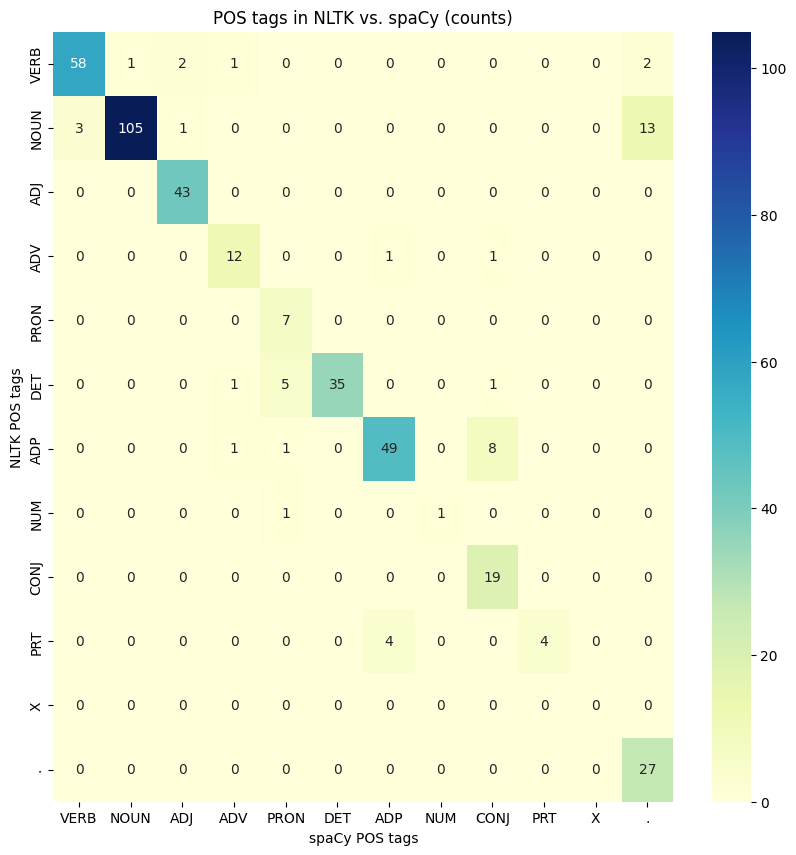

In [68]:
# create a matrix out of nltk_to_spacy_sum
nltk_to_spacy_sum_matrix = ar

# print the matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(nltk_to_spacy_sum_matrix, annot=True, fmt="d", cmap="YlGnBu", ax=ax)
ax.set_title("POS tags in NLTK vs. spaCy (counts)")
ax.set_ylabel("NLTK POS tags")
ax.set_xlabel("spaCy POS tags")
ax.set_xticklabels(UPOS)
ax.set_yticklabels(UPOS)
plt.savefig("../../data/plots/nltk-to-spacy-pos-tags.png")
plt.show()

C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_13644\2432994395.py:2: RuntimeWarning: invalid value encountered in divide
  nltk_to_spacy_sum_matrix_ratio = nltk_to_spacy_sum_matrix / nltk_to_spacy_sum_matrix.sum(axis=1).reshape(-1, 1)


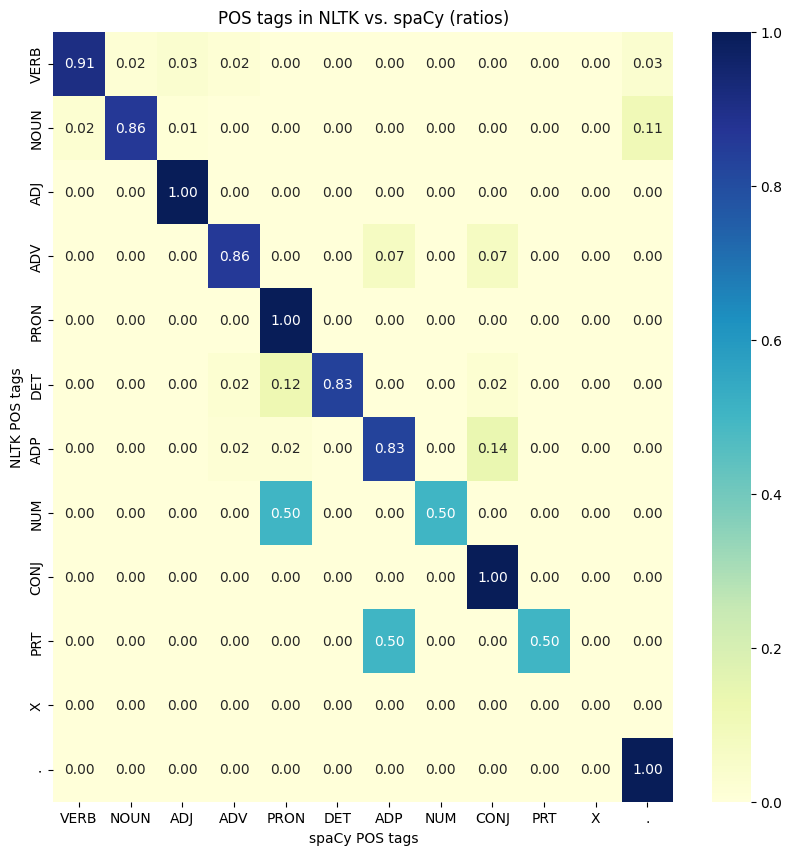

In [70]:
# create another matrix, with the ratio of each tag
nltk_to_spacy_sum_matrix_ratio = nltk_to_spacy_sum_matrix / nltk_to_spacy_sum_matrix.sum(axis=1).reshape(-1, 1)
nltk_to_spacy_sum_matrix_ratio[10] = [0]*12

# print the matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(nltk_to_spacy_sum_matrix_ratio, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
ax.set_title("POS tags in NLTK vs. spaCy (ratios)")
ax.set_ylabel("NLTK POS tags")
ax.set_xlabel("spaCy POS tags")
ax.set_xticklabels(UPOS)
ax.set_yticklabels(UPOS)
plt.savefig("../../data/plots/nltk-to-spacy-pos-tags-ratio.png")
plt.show()

Now we will do the same, from spaCy to NLTK.

In [101]:
spacy_to_nltk = pd.DataFrame()

for pos in UPOS:

    l = []

    for i, row in df.iterrows():

        # Collect all common tokens that have been classified as pos by spaCy
        pos_set = set([(elt[0], elt[1]) for elt in row["Spacy_tokens"] if elt[2] == pos and (elt[0], elt[1]) in row["common_tokens"]])
        
        # Create a dictionnary to count the number of times each pos has been classified as a specific POS tag by NLTK
        d = {tag: 0 for tag in UPOS}
        d["out_of"] = len(pos_set)

        for pos_elt in pos_set:

            # Find the equivalent token in NLTK tokens
            equiv_ = [elt for elt in row["NLTK_tokens"] if elt[0] == pos_elt[0] and elt[1] == pos_elt[1]]
            
            if len(equiv_) != 1:
                print(f"Error: {pos} found {len(equiv_)} times in NLTK tokens")
            else:
                # Increment the counter for the POS tag of the equivalent verb
                d[equiv_[0][2]] += 1

        l.append(d)

    spacy_to_nltk["spaCy_"+pos] = l

In [102]:
spacy_to_nltk.head()

,spaCy_VERB,spaCy_NOUN,spaCy_ADJ,spaCy_ADV,spaCy_PRON,spaCy_DET,spaCy_ADP,spaCy_NUM,spaCy_CONJ,spaCy_PRT,spaCy_X,spaCy_.
0,"{'VERB': 4, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 6, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 1, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 1, 'ADJ': 0, 'ADV': 0, 'PR..."
1,"{'VERB': 2, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 4, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 3, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 1, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR..."
2,"{'VERB': 2, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 8, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 1, 'ADJ': 0, 'ADV': 0, 'PR..."
3,"{'VERB': 6, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 7, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 4, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 3, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 1, 'ADJ': 0, 'ADV': 0, 'PR..."
4,"{'VERB': 4, 'NOUN': 1, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 5, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 1, 'ADV': 0, 'PR...","{'VERB': 1, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 1, 'ADJ': 0, 'ADV': 0, 'PR..."


Once again, an example below: in sentence 3, 4 tokens have been labelled as '.' by spaCy. 3 of them have also been labelled as '.' by NLTK, but one has been labelled as NOUN.

In [108]:
spacy_to_nltk.iloc[1]["spaCy_VERB"]

{'VERB': 2,
 'NOUN': 0,
 'ADJ': 0,
 'ADV': 0,
 'PRON': 0,
 'DET': 0,
 'ADP': 0,
 'NUM': 0,
 'CONJ': 0,
 'PRT': 0,
 'X': 0,
 '.': 0,
 'out_of': 2}

In [103]:
spacy_to_nltk.iloc[3]["spaCy_."]

{'VERB': 0,
 'NOUN': 1,
 'ADJ': 0,
 'ADV': 0,
 'PRON': 0,
 'DET': 0,
 'ADP': 0,
 'NUM': 0,
 'CONJ': 0,
 'PRT': 0,
 'X': 0,
 '.': 3,
 'out_of': 4}

In [104]:
print([tuple_ for tuple_ in df.iloc[3]["Spacy_tokens"] if tuple_[2] == "."])

[(',', 94, '.'), ('-', 160, '.'), ('..', 194, '.'), (',', 3, '.')]


In [105]:
print([tuple_ for tuple_ in df.iloc[3]["NLTK_tokens"] if tuple_[1] in [94, 160, 194, 3]])

[('..', 194, 'NOUN'), (',', 94, '.'), ('-', 160, '.'), (',', 3, '.')]


In [106]:
spacy_to_nltk_sum = pd.DataFrame(columns=spacy_to_nltk.columns)

# Sum the counts for each row
l = []
for col in spacy_to_nltk_sum.columns:

    # initialize the sum dictionnary
    d = {tag: 0 for tag in UPOS}
    d["out_of"] = 0

    for i, row in spacy_to_nltk.iterrows():

        # Sum the counts for each row
        d = {k: d[k] + row[col][k] for k in d}
    
    l.append(d)

spacy_to_nltk_sum.loc["sum"] = l
spacy_to_nltk_sum.head()

,spaCy_VERB,spaCy_NOUN,spaCy_ADJ,spaCy_ADV,spaCy_PRON,spaCy_DET,spaCy_ADP,spaCy_NUM,spaCy_CONJ,spaCy_PRT,spaCy_X,spaCy_.
sum,"{'VERB': 58, 'NOUN': 3, 'ADJ': 0, 'ADV': 0, 'P...","{'VERB': 1, 'NOUN': 105, 'ADJ': 0, 'ADV': 0, '...","{'VERB': 2, 'NOUN': 1, 'ADJ': 43, 'ADV': 0, 'P...","{'VERB': 1, 'NOUN': 0, 'ADJ': 0, 'ADV': 12, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 2, 'NOUN': 13, 'ADJ': 0, 'ADV': 0, 'P..."


In [109]:
# Now as an array
l = []
for col in spacy_to_nltk_sum.columns:

    d = spacy_to_nltk_sum.iloc[0][col]
    l.append(np.array([ val for tag, val in d.items() if tag != "out_of"]))
    
spacy_to_nltk_sum.loc["as_array"] = l

In [110]:
spacy_to_nltk_sum.head()

,spaCy_VERB,spaCy_NOUN,spaCy_ADJ,spaCy_ADV,spaCy_PRON,spaCy_DET,spaCy_ADP,spaCy_NUM,spaCy_CONJ,spaCy_PRT,spaCy_X,spaCy_.
sum,"{'VERB': 58, 'NOUN': 3, 'ADJ': 0, 'ADV': 0, 'P...","{'VERB': 1, 'NOUN': 105, 'ADJ': 0, 'ADV': 0, '...","{'VERB': 2, 'NOUN': 1, 'ADJ': 43, 'ADV': 0, 'P...","{'VERB': 1, 'NOUN': 0, 'ADJ': 0, 'ADV': 12, 'P...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 1, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 0, 'NOUN': 0, 'ADJ': 0, 'ADV': 0, 'PR...","{'VERB': 2, 'NOUN': 13, 'ADJ': 0, 'ADV': 0, 'P..."
as_array,"[58, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 105, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 1, 43, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[1, 0, 0, 12, 0, 1, 1, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 7, 5, 1, 1, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 35, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 49, 0, 0, 4, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 1, 8, 0, 19, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[2, 13, 0, 0, 0, 0, 0, 0, 0, 0, 0, 27]"


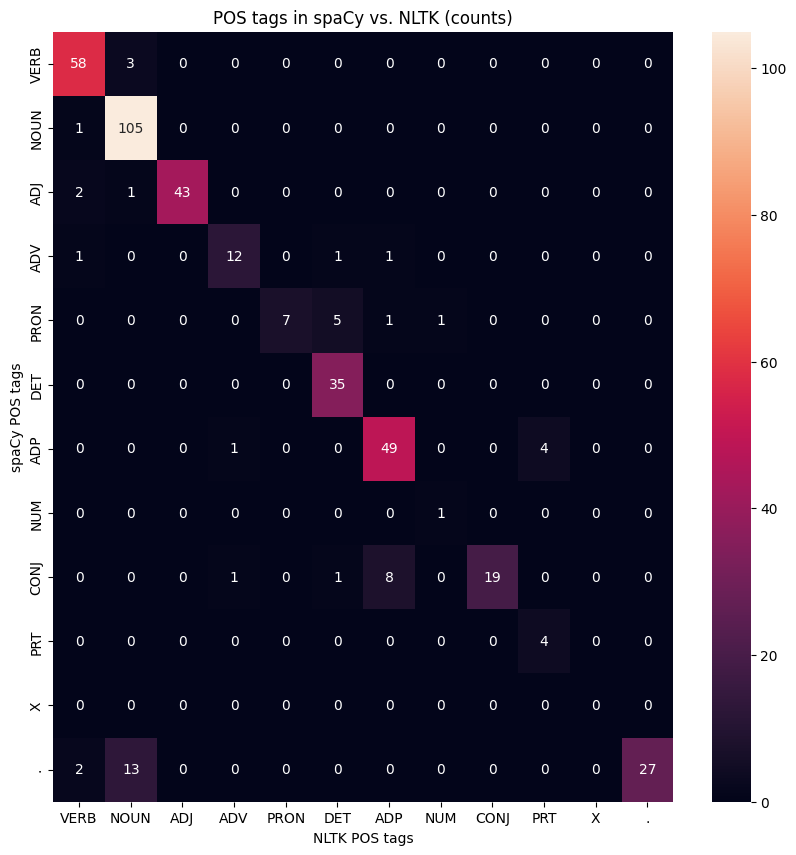

In [111]:
# create an array
ar = np.array(spacy_to_nltk_sum.loc["as_array"].tolist())

# create a matrix out 
spacy_to_nltk_sum_matrix = ar

# print the matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(spacy_to_nltk_sum_matrix, annot=True, fmt="d", ax=ax)
ax.set_title("POS tags in spaCy vs. NLTK (counts)")
ax.set_ylabel("spaCy POS tags")
ax.set_xlabel("NLTK POS tags")
ax.set_xticklabels(UPOS)
ax.set_yticklabels(UPOS)
plt.savefig("../../data/plots/spacy-to-nltk-pos-tags.png")
plt.show()

C:\Users\bleuze3u\AppData\Local\Temp\ipykernel_13644\2033882547.py:2: RuntimeWarning: invalid value encountered in divide
  spacy_to_nltk_sum_matrix_ratio = spacy_to_nltk_sum_matrix / spacy_to_nltk_sum_matrix.sum(axis=1).reshape(-1, 1)


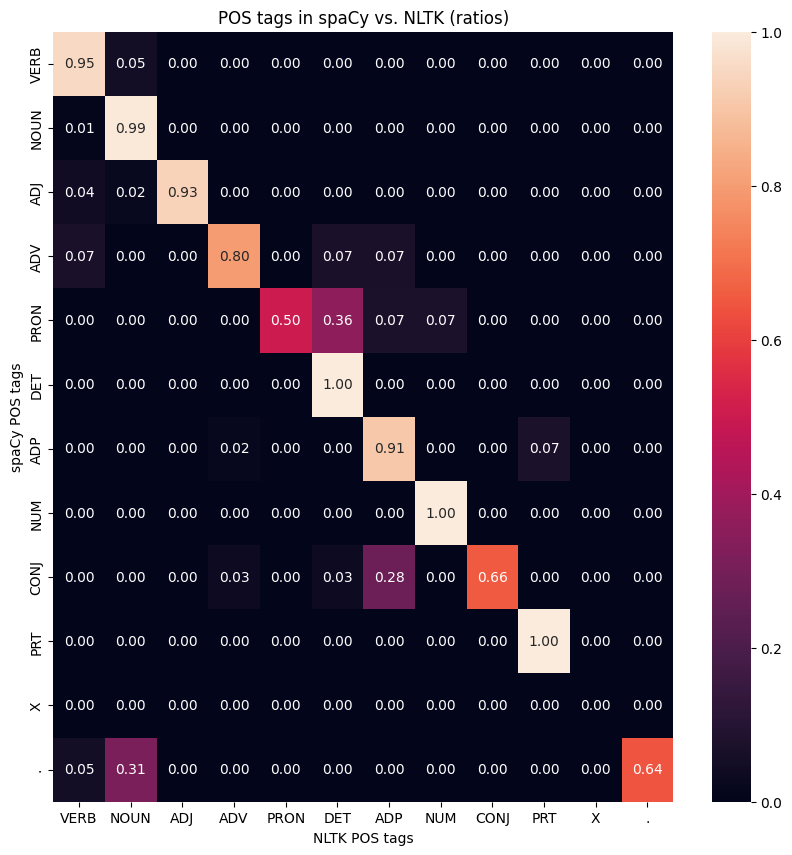

In [113]:
# create another matrix, with the ratio of each tag
spacy_to_nltk_sum_matrix_ratio = spacy_to_nltk_sum_matrix / spacy_to_nltk_sum_matrix.sum(axis=1).reshape(-1, 1)
spacy_to_nltk_sum_matrix_ratio[10] = [0]*12

# print the matrix as a heatmap
fig, ax = plt.subplots(figsize=(10, 10))
ax = sns.heatmap(spacy_to_nltk_sum_matrix_ratio, annot=True, fmt=".2f", ax=ax)
ax.set_title("POS tags in spaCy vs. NLTK (ratios)")
ax.set_ylabel("spaCy POS tags")
ax.set_xlabel("NLTK POS tags")
ax.set_xticklabels(UPOS)
ax.set_yticklabels(UPOS)
plt.savefig("../../data/plots/spacy-to-NLTK-pos-tags-ratio.png")
plt.show()